In [3]:
import networkx as nx
import random
import time
import statistics
from graph import Graph
import matplotlib.pyplot as plt
import gc
def convert_to_graph(nx_graph):
    net = {}
    for u in nx_graph.nodes():
        if u not in net:
            net[u] = {}

    for u, v, data in nx_graph.edges(data=True):
        capacity = data['capacity']
        if u not in net:
            net[u] = {}
        net[u][v] = {'capacity': capacity}
        
    source = min(nx_graph.nodes)
    sink = max(nx_graph.nodes)
    
    return Graph(net, source, sink)

def generate_gnm_graph(n, m, U):
    G = nx.gnm_random_graph(n, m, directed=True)
    for u, v in G.edges():
        G[u][v]['capacity'] = random.randint(1, U)
    return G

def generate_gnp_graph(n, p, U):
    G = nx.gnp_random_graph(n, p, directed=True)
    for u, v in G.edges():
        G[u][v]['capacity'] = random.randint(1, U)
    return G

def run_experiment(n, m, U, num_tests=50, method='gnm', p = 0.1):
    times_edmonds_karp = []
    times_push_relabel = []

    for _ in range(num_tests):
        if method == 'gnm':
            G = generate_gnm_graph(n, m, U)
        else:
            G = generate_gnp_graph(n, p, U)

        g, diGraph = convert_to_graph(G), G 

        # Edmonds-Karp
        start_time = time.time()
        max_flow_ek = g.edmonds_karp()
        end_time = time.time()
        times_edmonds_karp.append(end_time - start_time)

        # Push-Relabel
        start_time = time.time()
        max_flow_pr = g.FIFOPushRelabel()
        end_time = time.time()
        times_push_relabel.append(end_time - start_time)

        gc.collect()

    avg_time_ek = statistics.mean(times_edmonds_karp)
    worst_time_ek = max(times_edmonds_karp)
    avg_time_pr = statistics.mean(times_push_relabel)
    worst_time_pr = max(times_push_relabel)

    return (avg_time_ek, worst_time_ek, avg_time_pr, worst_time_pr)


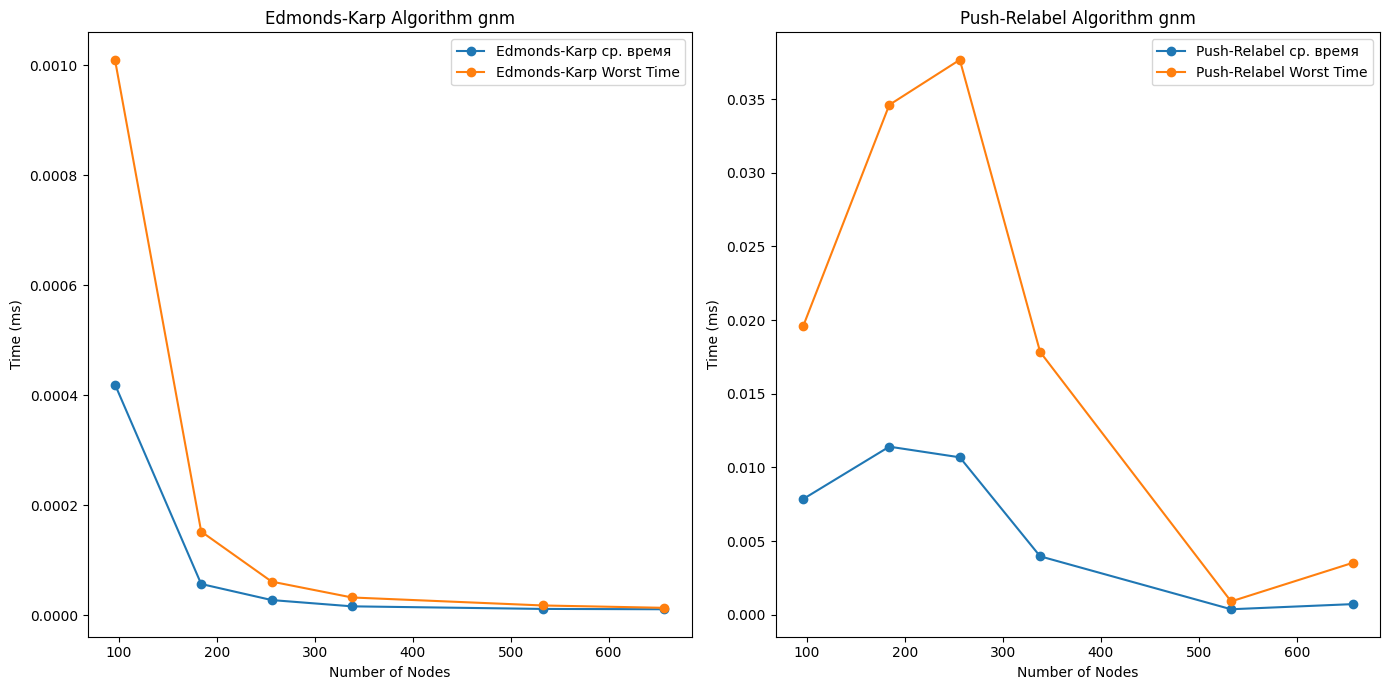

In [6]:
U = 100
num_tests = 10 
m = 300
nodes_list = [96, 184, 256, 338, 533, 657]

results_nodes = [run_experiment(n, m, U, num_tests) for n in nodes_list]

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
avg_times_ek = [result[0] for result in results_nodes]
worst_times_ek = [result[1] for result in results_nodes]
plt.plot(nodes_list, avg_times_ek, label='Edmonds-Karp ср. время', marker='o')
plt.plot(nodes_list, worst_times_ek, label='Edmonds-Karp Worst Time', marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (ms)')
plt.title('Edmonds-Karp Algorithm gnm')
plt.legend()

plt.subplot(1, 2, 2)
avg_times_pr = [result[2] for result in results_nodes]
worst_times_pr = [result[3] for result in results_nodes]
plt.plot(nodes_list, avg_times_pr, label='Push-Relabel ср. время', marker='o')
plt.plot(nodes_list, worst_times_pr, label='Push-Relabel Worst Time', marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (ms)')
plt.title('Push-Relabel Algorithm gnm')
plt.legend()

plt.tight_layout()
plt.show()



In [8]:
# p = 0.05  # тут не уверен, что подбирать по параметрам
U = 100
num_tests = 10 
m = 300
nodes_list = list(range(100, 1000, 98))

results_nodes = [run_experiment(n, m, U, num_tests, "gnp", 0.05) for n in nodes_list]

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
avg_times_ek = [result[0] for result in results_nodes]
worst_times_ek = [result[1] for result in results_nodes]
plt.plot(nodes_list, avg_times_ek, label='Edmonds-Karp ср. время', marker='o')
plt.plot(nodes_list, worst_times_ek, label='Edmonds-Karp худшее вермя', marker='o')
plt.xlabel('Кол-во вершин')
plt.ylabel('Время (sec)')
plt.title('Edmonds-Karp Algorithm gnp')
plt.legend()

plt.subplot(1, 2, 2)
avg_times_pr = [result[2] for result in results_nodes]
worst_times_pr = [result[3] for result in results_nodes]
plt.plot(nodes_list, avg_times_pr, label='Push-Relabel ср. время', marker='o')
plt.plot(nodes_list, worst_times_pr, label='Push-Relabel худшее вермя', marker='o')
plt.xlabel('Кол-во вершин')
plt.ylabel('Время (sec)')
plt.title('Push-Relabel Algorithm gnp')
plt.legend()

plt.tight_layout()
plt.show()


n = 50, m = 258, U = 10, ek ср. время: 0.0002960634231567383, pr ср. время: 0.0023343658447265627
n = 50, m = 344, U = 10, ek ср. время: 0.00045842647552490234, pr ср. время: 0.0037335443496704103
n = 50, m = 501, U = 10, ek ср. время: 0.0008069562911987304, pr ср. время: 0.00495697021484375
n = 50, m = 712, U = 10, ek ср. время: 0.0013217258453369141, pr ср. время: 0.004945716857910156
n = 50, m = 1123, U = 10, ek ср. время: 0.0028863811492919923, pr ср. время: 0.006360445022583008
n = 50, m = 258, U = 10000, ek ср. время: 0.0003879928588867187, pr ср. время: 0.0030846643447875978
n = 50, m = 344, U = 10000, ek ср. время: 0.0005070877075195313, pr ср. время: 0.003876457214355469
n = 50, m = 501, U = 10000, ek ср. время: 0.0009183359146118165, pr ср. время: 0.00417177677154541
n = 50, m = 712, U = 10000, ek ср. время: 0.0015892314910888672, pr ср. время: 0.006217408180236817
n = 50, m = 1123, U = 10000, ek ср. время: 0.003495302200317383, pr ср. время: 0.007205219268798828


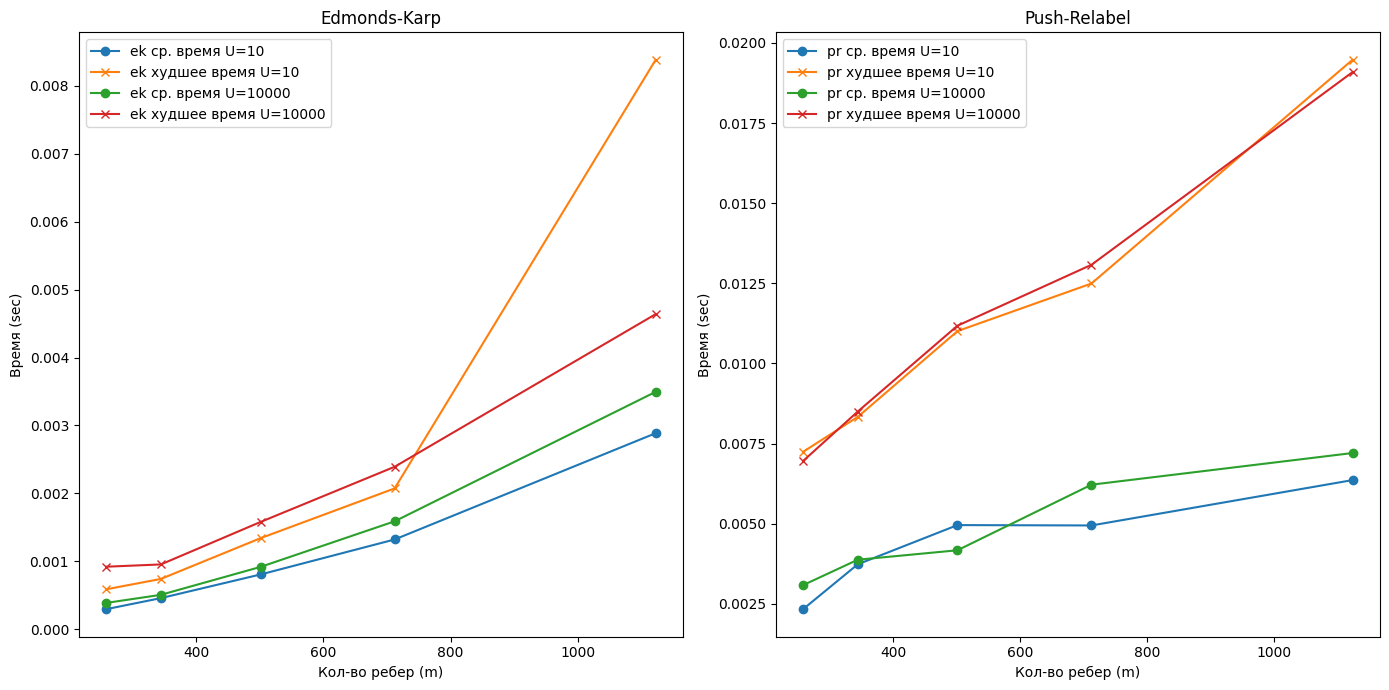

In [60]:
import pandas as pd

n = 50
U_values = [10, 10000]
m_values = [258, 344, 501, 712, 1123]
num_tests = 50 

results = {}

# for U in U_values:
#     for m in m_values:
#         avg_time_ek, worst_time_ek, avg_time_pr, worst_time_pr = run_experiment(n, m, U, num_tests)
#         results[(n, m, U)] = {'ek': avg_time_ek, 'pr': avg_time_pr}
#         print(f'n = {n}, m = {m}, U = {U}, ek ср. время: {avg_time_ek}, pr ср. время: {avg_time_pr}')

# for key, value in results.items():
#     n, m, U = key
#     ek_time = value['ek']
#     pl_time = value['pr']
#     print(f'pr: n = {n}, m = {m}, U = {U} ср. время: {pl_time}')
#     print(f'ek: n = {n}, m = {m}, U = {U} ср. время: {ek_time}')

results = []

for U in U_values:
    for m in m_values:
        avg_time_ek, worst_time_ek, avg_time_pr, worst_time_pr = run_experiment(n, m, U, num_tests)
        results.append({
            'n': n,
            'm': m,
            'U': U,
            'ek avg time': avg_time_ek,
            'ek worst time': worst_time_ek,
            'pr avg time': avg_time_pr,
            'pr worst time': worst_time_pr
        })
        print(f'n = {n}, m = {m}, U = {U}, ek ср. время: {avg_time_ek}, pr ср. время: {avg_time_pr}')

df = pd.DataFrame(results)
# print(df_results)

plt.figure(figsize=(14, 7))

for U in df['U'].unique():
    df_U = df[df['U'] == U]
    
    plt.subplot(1, 2, 1)
    plt.plot(df_U['m'], df_U['ek avg time'], label=f'ek ср. время U={U}', marker='o')
    plt.plot(df_U['m'], df_U['ek worst time'], label=f'ek худшее время U={U}', marker='x')

    plt.subplot(1, 2, 2)
    plt.plot(df_U['m'], df_U['pr avg time'], label=f'pr ср. время U={U}', marker='o')
    plt.plot(df_U['m'], df_U['pr worst time'], label=f'pr худшее время U={U}', marker='x')

plt.subplot(1, 2, 1)
plt.xlabel('Кол-во ребер (m)')
plt.ylabel('Время (sec)')
plt.title('Edmonds-Karp')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Кол-во ребер (m)')
plt.ylabel('Время (sec)')
plt.title('Push-Relabel')
plt.legend()

plt.tight_layout()
plt.show()